
# Домашнее задание по NLP # 1 [100 баллов]
Классификация по тональности

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.



## Часть 1. Анализ текстов [40/100]

- Посчитайте количество отзывов в разных городах и на разные банки
- Постройте гистограмы длин слов в символах и в словах
- Найдите 10 самых частых:
  - слов
  - слов без стоп-слов
  - лемм
  - существительных
- Постройте кривые Ципфа и Хипса
- Ответьте на следующие вопросы:
        какое слово встречается чаще, "сотрудник" или "клиент"?
        сколько раз встречается слова "мошенничество" и "доверие"?
- В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import re
from pymystem3 import Mystem
from pymorphy2 import MorphAnalyzer
from nltk.stem.snowball import RussianStemmer
from nltk import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
from pprint import pprint

import multiprocessing


In [3]:
m = Mystem()
regex = re.compile("[А-Яа-я]+")
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь', 'год', 'мой']

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""
    

def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

def stemming(text, stemmer = RussianStemmer()):
    try:
        return " ".join([stemmer.stem(w) for w in text.split()])
    except:
        return " "

def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""
    
def _apply_df(args):
    df, func, num, kwargs = args
    return num, df.apply(func, **kwargs)

def apply_by_multiprocessing(df,func,**kwargs):
    workers=kwargs.pop('workers')
    pool = multiprocessing.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, i, kwargs) for i,d in enumerate(np.array_split(df, workers))])
    pool.close()
    result=sorted(result,key=lambda x:x[0])
    return pd.concat([i[1] for i in result])    

#### Чтение и обработка данных

In [3]:
df_chunk = pd.read_json('./banki_responses.json.bz2', compression='bz2', lines=True, orient='records', chunksize=1000)
df = pd.concat(df_chunk, ignore_index=True)

In [4]:
df = df[df['rating_not_checked']==False]

In [5]:
df.shape

(153499, 10)

In [6]:
df.sample(5)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
37904,mam83,лицензия № 2766,ОТП Банк,г. Тула,2014-11-10 13:37:00,2,1.0,False,В октябре через сбербанк-онлайн по ошибке пере...,Банк не возвращает деньги
179065,ponka,лицензия № 1481,Сбербанк России,г. Самара,2010-07-30 20:37:00,6,1.0,False,17.07.2010 я обратилась в Кировское отделение ...,Надоело
28316,vnykovat,лицензия № 2289,Русский Стандарт,г. Москва,2014-12-25 00:24:00,1,NaN,False,С 2.12 и ежедневно мне звонил представитель ба...,Непрофессиональность сотрудников банка
175750,mstik,лицензия № 3279,Национальный Банк «Траст»,г. Москва,2010-12-01 20:51:00,0,1.0,False,"01 декабря 2010 г, пришел я в Операционный офи...",Анархия по обслуживанию клиентов
192845,NightRider,лицензия № 2272,Росбанк,NaN,2008-01-14 14:44:00,4,1.0,False,"Для меня загадка, как этот Росбанк еще продолж...","Привет от ""благодарных"" клиентов!"


#### Отзывы по разным готодам и банкам

In [7]:
regex1 = re.compile("[А-Яа-я0-9]+")

df['bank_name'].apply(lambda x: words_only(x,regex=regex1)).str.lower().value_counts().head(10)

сбербанк россии            26327
альфа банк                 10224
втб 24                      8185
русский стандарт            7943
хоум кредит банк            7549
тинькофф банк               5387
национальный банк траст     4607
ренессанс кредит            3849
связной банк                3775
отп банк                    3237
Name: bank_name, dtype: int64

In [8]:
df['city'].apply(lambda x: words_only(x,regex=regex1)).str.lower().value_counts().head(10)

г москва             56727
                     15174
г санкт петербург    14992
г новосибирск         2379
г екатеринбург        2374
г нижний новгород     2035
г ростов на дону      2022
г самара              1784
г челябинск           1551
г казань              1515
Name: city, dtype: int64

#### Длина отзывов в словах и символах

In [9]:
#длина в символах
len_chars = df.text.apply(len)
len_chars.describe()

count    153499.000000
mean       1554.212790
std        1319.098042
min          23.000000
25%         732.000000
50%        1193.000000
75%        1929.000000
max       32082.000000
Name: text, dtype: float64

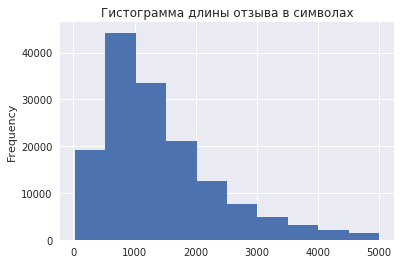

In [10]:
len_chars[len_chars < 5000].plot(kind='hist', title='Гистограмма длины отзыва в символах')

In [11]:
df.text = df.text.str.lower()
df.text = apply_by_multiprocessing(df.text, words_only,  workers=4)

df.text.head()

5     добрый день я не являюсь клиентом банка и пору...
6     доброго дня являюсь держателем зарплатной карт...
11    здравствуйте дублирую свое заявление от в до м...
15    добрый день я открыл расчетный счет в сбербанк...
28    г взяла кредит в вашем банке заявленная мною с...
Name: text, dtype: object

In [12]:
#длина в словах
len_tokens = df.text.str.split().apply(len)
len_tokens.describe()

count    153499.000000
mean        230.811751
std         196.607612
min           0.000000
25%         108.000000
50%         177.000000
75%         287.000000
max        5001.000000
Name: text, dtype: float64

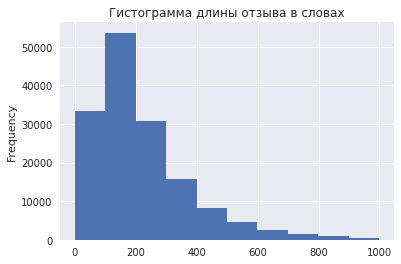

In [13]:
len_tokens[len_tokens < 1000].plot(kind='hist', title='Гистограмма длины отзыва в словах')

#### top10 слов

In [14]:
#top10 слов
tokens = []
for _, row in df.iterrows():
    tokens += row['text'].split()
fd = FreqDist(tokens)
for i in fd.most_common(10):
    print(i)

('в', 1330550)
('и', 1058997)
('не', 855335)
('на', 707935)
('что', 640057)
('я', 577500)
('с', 464037)
('по', 372769)
('мне', 320958)
('банка', 275906)


In [15]:
%%time

df.text = apply_by_multiprocessing(df.text, remove_stopwords,  workers=4)

CPU times: user 2.83 s, sys: 3.33 s, total: 6.16 s
Wall time: 49.1 s


In [16]:
#top10 без стоп-слов
tokens = []
for _, row in df.iterrows():
    tokens += row['text'].split()
fd = FreqDist(tokens)
for i in fd.most_common(10):
    print(i)

('банка', 275906)
('банк', 215426)
('деньги', 131201)
('карту', 105829)
('карты', 101821)
('кредит', 81136)
('день', 76552)
('банке', 72169)
('заявление', 70423)
('очень', 66824)


In [17]:
%%time

df.text = apply_by_multiprocessing(df.text, lemmatize,  workers=4)
df.text = apply_by_multiprocessing(df.text, remove_stoplemmas,  workers=4)
df.dropna(subset=['text'], inplace=True)


CPU times: user 5.58 s, sys: 4.38 s, total: 9.95 s
Wall time: 9min 4s


In [18]:
df.text.iloc[0]

'добрый день являться клиент банк поручитель кредитный договор являться какой либо другой лицо письменно оформлять отношение банк повод урегулирование чей либо задолженность начинать марта начинать приходить бесконечный письмо ооо примо коллект адрес город москва уваровский переулок дом квартира угроза возбуждение уголовный дело отношение гражданин филиппов эдуард владимирович уклоняться уплата взять кредит договор договор весь ответственность хотеть заверять вышеуказанный гражданин разыскивать знакомый адрес зарегистрировать какой образ удостоверяться подлинность документ оформлять имя кредитный договор меньший мера понятно почему ваш милость должный переживать бояться имущество письмо доставлять серьезный неудобство нарушать гражданский право нарушать закон защита персональный данные убедительно просить прекращать посылать адрес письмо угроза вопрос иметь отношение случай отклонение претензия быть вынужденный обращаться жалоба другой орган росспотребнадзор центральный банк служба фин

In [6]:
#top10 лемм
tokens = []
types = set()
n_types = []
n_tokens = []
for _, row in df.iterrows():
    tokens += row['text'].split()
    types.update(row['text'].split())
    n_tokens.append(len(tokens))
    n_types.append(len(types))
fd = FreqDist(tokens)
for i in fd.most_common(10):
    print(i)

('банк', 623032)
('карта', 334999)
('деньги', 179734)
('день', 173043)
('кредит', 156177)
('отделение', 144050)
('клиент', 136892)
('сотрудник', 134168)
('счет', 126894)
('сказать', 114494)


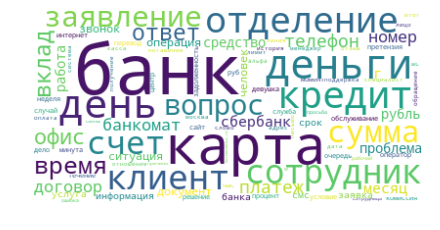

In [37]:
#top существительных
ma = MorphAnalyzer()
word_freq = []
for i in fd.most_common(200):
    p = ma.parse(i[0])[0].tag
    if {'NOUN'} in p:
        word_freq.append(i)
wd = WordCloud(background_color = 'white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure(figsize=(7,4))
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()
        

In [21]:
df.to_csv('./banki_lemmatize.csv.bz2', compression='bz2')

In [4]:
df = pd.read_csv('./banki_lemmatize.csv.bz2', compression='bz2', index_col=0)

In [5]:
df.head(2)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
5,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,добрый день являться клиент банк поручитель кр...,Жалоба
6,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,добрый день являться держатель зарплатной карт...,Не могу пользоваться услугой Сбербанк он-лайн


In [6]:
df.dropna(subset=['text'], inplace=True)
df.shape

(153497, 10)

#### какое слово встречается чаще, "сотрудник" или "клиент"?

In [25]:
#какое слово встречается чаще, "сотрудник" или "клиент"?
fd['сотрудник'] > fd['клиент']

False

#### сколько раз встречается слова "мошенничество" и "доверие"?

In [26]:
#сколько раз встречается слова "мошенничество" и "доверие"?
fd['мошенничество'], fd['доверие']

(3244, 2108)

#### Закон Ципфа

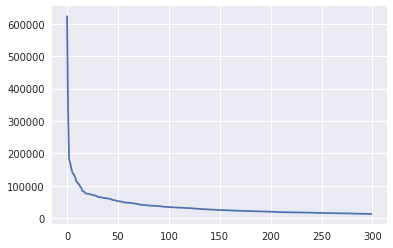

In [27]:
#Закон Ципфа
freqs = list(fd.values())
freqs = sorted(freqs, reverse = True)
fig, ax = plt.subplots()
ax.plot( range(300), freqs[:300])
plt.show()

#### Закон Хипса

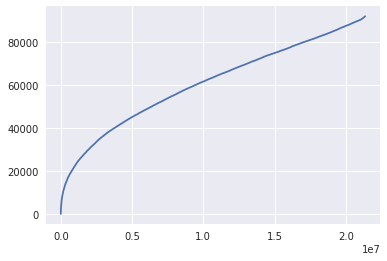

In [28]:
#Закон Хипса
fig, ax = plt.subplots()
ax.plot(n_tokens, n_types)
plt.show()

#### tf-idf для поиска ключевых слов и биграм 

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [170]:
#Для отзывов без оценки заполним оценку нулем. Для того, чтобы эти отзывы попали в общий корпус документов
df['rating_grade'].fillna(0.0, inplace=True)

In [21]:
df['rating_grade'].value_counts()

0.0    64840
1.0    47386
5.0    14713
2.0    13509
3.0     9261
4.0     3788
Name: rating_grade, dtype: int64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153497 entries, 5 to 201029
Data columns (total 10 columns):
author                153472 non-null object
bank_license          153496 non-null object
bank_name             153497 non-null object
city                  138325 non-null object
datetime              153497 non-null object
num_comments          153497 non-null int64
rating_grade          153497 non-null float64
rating_not_checked    153497 non-null bool
text                  153497 non-null object
title                 152274 non-null object
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 11.9+ MB


In [125]:
tokens_by_topic = []
for topic in df['rating_grade'].unique():
    tokens = []
    sample = df[df['rating_grade']==topic]
    for i in range(len(sample)):
        tokens += sample.text.iloc[i].split()
    tokens_by_topic.append(tokens)

##### юниграммы 

In [126]:
#отрицатеьные отзывы
event_id = 2
df['rating_grade'].unique()[event_id]

1.0

In [127]:
# юниграммы 
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 5)
X_train =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])

In [128]:
X_train.shape

(6, 18937)

In [129]:
repr(X_train[event_id])

"<1x18937 sparse matrix of type '<class 'numpy.float64'>'\n\twith 18899 stored elements in Compressed Sparse Row format>"

In [130]:
max_value = X_train[event_id].toarray().ravel()
max_value.shape

(18937,)

In [131]:
sorted_by_tfidf = max_value.argsort()
sorted_by_tfidf

array([ 1271, 11270, 14860, ...,  3172,  5519,   600])

In [132]:
feature_names = np.array(tfidf.get_feature_names())
feature_names

array(['аа', 'ааа', 'аааа', ..., 'ящик', 'ящичек', 'яя'], dtype='<U24')

In [133]:
#признаки с наибольшими значениями tfidf в отрицательных отзывах
pprint(feature_names[sorted_by_tfidf[-20:]].tolist())

['офис',
 'звонить',
 'такой',
 'приходить',
 'ответ',
 'время',
 'вопрос',
 'получать',
 'сумма',
 'заявление',
 'сказать',
 'клиент',
 'счет',
 'сотрудник',
 'кредит',
 'отделение',
 'день',
 'деньги',
 'карта',
 'банк']


In [134]:
#положительные отзывы

event_id = 3
df['rating_grade'].unique()[event_id]


5.0

In [135]:
max_value = X_train[event_id].toarray().ravel()
sorted_by_tfidf = max_value.argsort()
feature_names = np.array(tfidf.get_feature_names())

In [136]:
#признаки с наибольшими значениями tfidf в положительных отзывах
pprint(feature_names[sorted_by_tfidf[-20:]].tolist())

['другой',
 'проблема',
 'сказать',
 'обслуживание',
 'получать',
 'работа',
 'счет',
 'офис',
 'время',
 'вопрос',
 'вклад',
 'деньги',
 'сотрудник',
 'отделение',
 'клиент',
 'кредит',
 'день',
 'очень',
 'карта',
 'банк']


##### биграммы

In [137]:

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
X_train =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])

In [138]:
#отрицатеьные отзывы
event_id = 2
df['rating_grade'].unique()[event_id]

1.0

In [139]:
max_value = X_train[event_id].toarray().ravel()
sorted_by_tfidf = max_value.argsort()
feature_names = np.array(tfidf.get_feature_names())
#признаки с наибольшими значениями tfidf в отрицатеьных отзывах
pprint(feature_names[sorted_by_tfidf[-20:]].tolist())

['кредитный история',
 'досрочный погашение',
 'получать ответ',
 'приходить смс',
 'добрый день',
 'служба поддержка',
 'альфа банк',
 'другой банк',
 'интернет банк',
 'следующий день',
 'клиент банк',
 'ваш банк',
 'колл центр',
 'рабочий день',
 'горячий линия',
 'написать заявление',
 'денежный средство',
 'отделение банк',
 'кредитный карта',
 'сотрудник банк']


In [140]:
#положительные отзывы
event_id = 3
df['rating_grade'].unique()[event_id]

5.0

In [141]:
max_value = X_train[event_id].toarray().ravel()
sorted_by_tfidf = max_value.argsort()
feature_names = np.array(tfidf.get_feature_names())
#признаки с наибольшими значениями tfidf в положительных отзывах
pprint(feature_names[sorted_by_tfidf[-20:]].tolist())

['данный банк',
 'очень быстро',
 'банк очень',
 'выражать благодарность',
 'очень довольный',
 'процентный ставка',
 'колл центр',
 'рабочий день',
 'альфа банк',
 'добрый день',
 'дебетовый карта',
 'являться клиент',
 'отделение банк',
 'следующий день',
 'открывать вклад',
 'клиент банк',
 'сотрудник банк',
 'кредитный карта',
 'другой банк',
 'интернет банк']


In [160]:
del X_train, tokens, tokens_by_topic


## Часть 2. Тематическое моделирование [20/100]

- Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
- Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim.


In [155]:
from gensim.corpora import Dictionary
from gensim.models import  LsiModel, LdaModel, TfidfModel
from gensim import similarities

In [143]:
texts = [df.text.iloc[i].split() for i in range(len(df))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [157]:
print(dictionary)

Dictionary(91906 unique tokens: ['адрес', 'банк', 'бесконечный', 'бояться', 'быть']...)


In [156]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [159]:
print(texts[0])
print(corpus[0])
print(corpus_tfidf[0])

['добрый', 'день', 'являться', 'клиент', 'банк', 'поручитель', 'кредитный', 'договор', 'являться', 'какой', 'либо', 'другой', 'лицо', 'письменно', 'оформлять', 'отношение', 'банк', 'повод', 'урегулирование', 'чей', 'либо', 'задолженность', 'начинать', 'марта', 'начинать', 'приходить', 'бесконечный', 'письмо', 'ооо', 'примо', 'коллект', 'адрес', 'город', 'москва', 'уваровский', 'переулок', 'дом', 'квартира', 'угроза', 'возбуждение', 'уголовный', 'дело', 'отношение', 'гражданин', 'филиппов', 'эдуард', 'владимирович', 'уклоняться', 'уплата', 'взять', 'кредит', 'договор', 'договор', 'весь', 'ответственность', 'хотеть', 'заверять', 'вышеуказанный', 'гражданин', 'разыскивать', 'знакомый', 'адрес', 'зарегистрировать', 'какой', 'образ', 'удостоверяться', 'подлинность', 'документ', 'оформлять', 'имя', 'кредитный', 'договор', 'меньший', 'мера', 'понятно', 'почему', 'ваш', 'милость', 'должный', 'переживать', 'бояться', 'имущество', 'письмо', 'доставлять', 'серьезный', 'неудобство', 'нарушать', 'г

#### LSI - 5 topics

In [164]:
lsi = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)
lsi.show_topics(5)

[(0,
  '0.194*"карта" + 0.134*"кредит" + 0.115*"деньги" + 0.109*"заявление" + 0.107*"счет" + 0.101*"вклад" + 0.101*"банкомат" + 0.100*"отделение" + 0.096*"сбербанк" + 0.096*"сумма"'),
 (1,
  '-0.487*"вклад" + 0.321*"кредит" + 0.157*"страховка" + -0.153*"открывать" + 0.149*"платеж" + 0.143*"задолженность" + 0.132*"погашение" + -0.131*"очередь" + -0.119*"банкомат" + -0.114*"карта"'),
 (2,
  '-0.378*"вклад" + 0.267*"банкомат" + 0.267*"карта" + -0.223*"кредит" + 0.205*"сбербанк" + -0.153*"страховка" + 0.143*"операция" + -0.137*"договор" + 0.130*"средство" + 0.128*"деньги"'),
 (3,
  '-0.285*"вклад" + 0.211*"заявка" + -0.211*"сумма" + 0.193*"номер" + -0.177*"руб" + -0.164*"договор" + -0.161*"платеж" + -0.150*"погашение" + 0.149*"звонок" + -0.145*"процент"'),
 (4,
  '0.283*"номер" + 0.276*"вклад" + 0.243*"звонок" + -0.243*"страховка" + -0.186*"заявка" + 0.174*"ваш" + 0.137*"телефон" + 0.136*"персональный" + 0.131*"база" + 0.130*"удалять"')]

#### LDA - 5 topics

In [168]:
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5,
                        alpha='auto', eta='auto', iterations = 20, passes = 5)
lda.show_topics(5)

/home/max/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


[(0,
  '0.055*"карта" + 0.024*"банк" + 0.020*"деньги" + 0.015*"банкомат" + 0.014*"счет" + 0.011*"день" + 0.007*"получать" + 0.007*"сказать" + 0.006*"отделение" + 0.006*"интернет"'),
 (1,
  '0.046*"кредит" + 0.034*"банк" + 0.017*"кредитный" + 0.016*"сумма" + 0.014*"день" + 0.013*"платеж" + 0.011*"договор" + 0.011*"документ" + 0.010*"месяц" + 0.009*"сказать"'),
 (2,
  '0.024*"банк" + 0.011*"клиент" + 0.011*"отделение" + 0.009*"вклад" + 0.008*"работать" + 0.008*"очень" + 0.008*"офис" + 0.007*"очередь" + 0.007*"время" + 0.006*"работа"'),
 (3,
  '0.031*"банк" + 0.022*"звонить" + 0.020*"телефон" + 0.015*"звонок" + 0.012*"ваш" + 0.012*"сотрудник" + 0.012*"номер" + 0.009*"позвонить" + 0.008*"отвечать" + 0.008*"говорить"'),
 (4,
  '0.033*"банк" + 0.019*"счет" + 0.015*"заявление" + 0.014*"г" + 0.011*"средство" + 0.009*"данный" + 0.009*"деньги" + 0.009*"договор" + 0.009*"претензия" + 0.008*"ответ"')]

#### LSI - 10 topics


In [166]:
lsi = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)
lsi.show_topics(10)

[(0,
  '0.194*"карта" + 0.133*"кредит" + 0.115*"деньги" + 0.109*"заявление" + 0.107*"счет" + 0.101*"вклад" + 0.101*"банкомат" + 0.100*"отделение" + 0.096*"сбербанк" + 0.096*"сумма"'),
 (1,
  '-0.467*"вклад" + 0.329*"кредит" + 0.158*"платеж" + -0.151*"банкомат" + 0.149*"задолженность" + -0.147*"открывать" + 0.147*"страховка" + 0.136*"погашение" + -0.125*"карта" + -0.124*"очередь"'),
 (2,
  '-0.412*"вклад" + 0.293*"банкомат" + 0.246*"карта" + 0.210*"сбербанк" + -0.199*"кредит" + -0.139*"договор" + 0.139*"операция" + 0.133*"деньги" + 0.126*"средство" + -0.125*"страховка"'),
 (3,
  '-0.283*"вклад" + -0.215*"сумма" + 0.201*"заявка" + 0.184*"номер" + -0.181*"руб" + -0.160*"платеж" + -0.154*"погашение" + -0.154*"договор" + -0.145*"процент" + -0.144*"рубль"'),
 (4,
  '-0.444*"карта" + 0.298*"банкомат" + -0.196*"лимит" + -0.188*"кредитный" + 0.161*"номер" + 0.126*"деньги" + 0.125*"терминал" + 0.123*"звонок" + 0.119*"купюра" + -0.116*"комиссия"'),
 (5,
  '-0.317*"банкомат" + 0.289*"вклад" + -0.2

#### LDA - 10 topics

In [169]:
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10,
                        alpha='auto', eta='auto', iterations = 20, passes = 5)
lda.show_topics(10)

/home/max/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


[(0,
  '0.030*"банк" + 0.027*"день" + 0.019*"позвонить" + 0.018*"звонить" + 0.018*"телефон" + 0.017*"ответ" + 0.013*"вопрос" + 0.013*"сказать" + 0.013*"номер" + 0.012*"заявление"'),
 (1,
  '0.068*"деньги" + 0.048*"банкомат" + 0.036*"счет" + 0.022*"банк" + 0.019*"карта" + 0.018*"снимать" + 0.018*"операция" + 0.016*"средство" + 0.015*"сумма" + 0.013*"день"'),
 (2,
  '0.058*"банк" + 0.021*"вклад" + 0.016*"клиент" + 0.014*"очень" + 0.010*"обслуживание" + 0.009*"открывать" + 0.009*"счет" + 0.006*"работа" + 0.006*"сайт" + 0.006*"время"'),
 (3,
  '0.012*"человек" + 0.012*"такой" + 0.012*"банк" + 0.010*"говорить" + 0.010*"клиент" + 0.009*"просто" + 0.009*"знать" + 0.008*"девушка" + 0.006*"понимать" + 0.006*"думать"'),
 (4,
  '0.038*"банк" + 0.016*"договор" + 0.013*"г" + 0.012*"данный" + 0.011*"сотрудник" + 0.010*"клиент" + 0.008*"заявление" + 0.007*"документ" + 0.007*"лицо" + 0.007*"ваш"'),
 (5,
  '0.039*"отделение" + 0.020*"очередь" + 0.020*"офис" + 0.015*"работать" + 0.013*"минута" + 0.012*"

#### Интерпретация

примеры понятных тем:
- особенности обслуживания в Сбербанке (0 и 2 в LSI-5)
- телефонные продажи продуктов (4 в LSI-5)
- про карты и банкоматы (0 в LDA-5, 4 в LSI-10, 1 в LDA-10)
- про кредитные продукты (1 в LDA-5)
- про работу отделений (2 в LDA-5, 5 в LDA-10)
- обращения по телефону (3 в LDA-5, 0 в LDA-10)
- про Киви кошелек и оплату услуг (7,9 в LSI-10)
- про страхование (8 в LSI-10)
- человеческое общение (3 в LDA-10)
- про коллекторов (6 в LDA-10)
- оформление кредитного договора (7 в LDA-10)
- график платежей (8 в LDA-10)
- оформление карты (9 в LDA-10)

Увеличение числа топиков с 5 до 10 позволило уловить больше различий между похожими документами, например, тема про кредиты в LDA-5, в LDA-10 была разделена на несколько, оформление кредитного договора + график платежей.

Наличие в темах названий конкретных зеленых банков говорит о том, что часть отзывов в большей мере относится к особенностям работы этой кредитной организации. Анализ bank_name ранее показал, что отзывы про Срербанк превышают суммарные отзывы всех остальных банков вместе взятых. 


## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

- Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.    
- Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.
- Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
- 1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).

Используйте accuracy и F-measure для оценки качества классификации.

Ниже написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV,  train_test_split
from sklearn.metrics import accuracy_score, classification_report

В качестве Baseline будем использовать модели RandomForestClassifier, LogisticRegression  с базовой векторизацией CountVectorizer. 

Далее добавим в модель векторизации Tfidf, LSI и LDA и сравним точность с baseline.

Далее у самой лучшей модели найдем оптимальные параметры с помощью GridSearchCV

Т.к. положительный и отрицательный классы являются несбалансированными, то при разбиении на train/test и кроссвалидации будем использовать стратифицированные выборки.

#### Baseline - CountVectorizer

In [9]:
df.sample(2)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
52215,Anna_msg,лицензия № 2289,Русский Стандарт,г. Калининград,2014-08-03 15:04:00,0,NaN,False,здравствовать получение дистанционный комплект...,"О закрытии вклада ""Накопительный счет"""
99428,kern_dm,лицензия № 2241,Киви Банк,г. Шатура,2013-09-09 23:04:00,0,1.0,False,вряд сообщать новый судя отзыв данный портал в...,Ограничение на исходящие операции


In [10]:
df = df[df['rating_grade'].isin([1.0, 5.0])]
df['rating_grade'].value_counts()

1.0    47386
5.0    14713
Name: rating_grade, dtype: int64

In [11]:
le = LabelEncoder()
df['rating_grade'] = le.fit_transform(df['rating_grade'])
df['rating_grade'].value_counts()

0    47386
1    14713
Name: rating_grade, dtype: int64

In [12]:
X_full = df['text']
y_full = df['rating_grade']
X_full.shape, y_full.shape

((62099,), (62099,))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.30, stratify=y_full, random_state=42)
y_train.value_counts()

0    33170
1    10299
Name: rating_grade, dtype: int64

##### LogisticRegression

In [17]:
base_lr = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression())
])
base_lr.fit(X_train, y_train)
predict_train = base_lr.predict(X_train)
predict_test = base_lr.predict(X_test)
print("Accuracy train: {0:6.4f}".format(accuracy_score(y_train, predict_train)))
print("Accuracy test: {0:6.4f}".format(accuracy_score(y_test, predict_test)))
print(classification_report(y_test, predict_test))

Accuracy train: 0.9976
Accuracy test: 0.9597
             precision    recall  f1-score   support

          0       0.97      0.97      0.97     14216
          1       0.92      0.91      0.91      4414

avg / total       0.96      0.96      0.96     18630



##### RandomForestClassifier

In [218]:
base_rf = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', RandomForestClassifier())
])
base_rf.fit(X_train, y_train)
predict_train = base_rf.predict(X_train)
predict_test = base_rf.predict(X_test)
print("Accuracy train: {0:6.4f}".format(accuracy_score(y_train, predict_train)))
print("Accuracy test: {0:6.4f}".format(accuracy_score(y_test, predict_test)))
print(classification_report(y_test, predict_test))

Accuracy train: 0.9925
Accuracy test: 0.8775
             precision    recall  f1-score   support

          0       0.87      0.99      0.93     14216
          1       0.95      0.51      0.66      4414

avg / total       0.89      0.88      0.86     18630



#### TF-IDF

##### LogisticRegression

In [219]:
tfidf_lr = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())
])
tfidf_lr.fit(X_train, y_train)
predict_train = tfidf_lr.predict(X_train)
predict_test = tfidf_lr.predict(X_test)
print("Accuracy train: {0:6.4f}".format(accuracy_score(y_train, predict_train)))
print("Accuracy test: {0:6.4f}".format(accuracy_score(y_test, predict_test)))
print(classification_report(y_test, predict_test))

Accuracy train: 0.9709
Accuracy test: 0.9626
             precision    recall  f1-score   support

          0       0.96      0.99      0.98     14216
          1       0.96      0.87      0.92      4414

avg / total       0.96      0.96      0.96     18630



##### RandomForestClassifier

In [220]:
tfidf_rf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier())
])
tfidf_rf.fit(X_train, y_train)
predict_train = tfidf_rf.predict(X_train)
predict_test = tfidf_rf.predict(X_test)
print("Accuracy train: {0:6.4f}".format(accuracy_score(y_train, predict_train)))
print("Accuracy test: {0:6.4f}".format(accuracy_score(y_test, predict_test)))
print(classification_report(y_test, predict_test))

Accuracy train: 0.9939
Accuracy test: 0.8824
             precision    recall  f1-score   support

          0       0.87      0.99      0.93     14216
          1       0.94      0.54      0.68      4414

avg / total       0.89      0.88      0.87     18630



#### TF-IDF + TruncatedSVD

##### LogisticRegression

In [232]:
lsi_lr = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lsi', TruncatedSVD(n_components=30)),
    ('clf', LogisticRegression())
])
lsi_lr.fit(X_train, y_train)
predict_train = lsi_lr.predict(X_train)
predict_test = lsi_lr.predict(X_test)
print("Accuracy train: {0:6.4f}".format(accuracy_score(y_train, predict_train)))
print("Accuracy test: {0:6.4f}".format(accuracy_score(y_test, predict_test)))
print(classification_report(y_test, predict_test))

Accuracy train: 0.9286
Accuracy test: 0.9301
             precision    recall  f1-score   support

          0       0.94      0.97      0.96     14216
          1       0.90      0.79      0.84      4414

avg / total       0.93      0.93      0.93     18630



##### RandomForestClassifier

In [233]:
lsi_rf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lsi', TruncatedSVD(n_components=30)),
    ('clf', RandomForestClassifier())
])
lsi_rf.fit(X_train, y_train)
predict_train = lsi_rf.predict(X_train)
predict_test = lsi_rf.predict(X_test)
print("Accuracy train: {0:6.4f}".format(accuracy_score(y_train, predict_train)))
print("Accuracy test: {0:6.4f}".format(accuracy_score(y_test, predict_test)))
print(classification_report(y_test, predict_test))

Accuracy train: 0.9918
Accuracy test: 0.9033
             precision    recall  f1-score   support

          0       0.90      0.98      0.94     14216
          1       0.91      0.66      0.76      4414

avg / total       0.90      0.90      0.90     18630



#### LDA

##### LogisticRegression

In [230]:
lda_lr = Pipeline([
    ('vect', CountVectorizer()),
    ('lda', LatentDirichletAllocation()),
    ('clf', LogisticRegression())
])
lda_lr.fit(X_train, y_train)
predict_train = lda_lr.predict(X_train)
predict_test = lda_lr.predict(X_test)
print("Accuracy train: {0:6.4f}".format(accuracy_score(y_train, predict_train)))
print("Accuracy test: {0:6.4f}".format(accuracy_score(y_test, predict_test)))
print(classification_report(y_test, predict_test))

/home/max/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Accuracy train: 0.9101
Accuracy test: 0.9090
             precision    recall  f1-score   support

          0       0.92      0.96      0.94     14216
          1       0.85      0.75      0.80      4414

avg / total       0.91      0.91      0.91     18630



##### RandomForestClassifier

In [231]:
lda_rf = Pipeline([
    ('vect', CountVectorizer()),
    ('lda', LatentDirichletAllocation()),
    ('clf', RandomForestClassifier())
])
lda_rf.fit(X_train, y_train)
predict_train = lda_rf.predict(X_train)
predict_test = lda_rf.predict(X_test)
print("Accuracy train: {0:6.4f}".format(accuracy_score(y_train, predict_train)))
print("Accuracy test: {0:6.4f}".format(accuracy_score(y_test, predict_test)))
print(classification_report(y_test, predict_test))

/home/max/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Accuracy train: 0.9902
Accuracy test: 0.9025
             precision    recall  f1-score   support

          0       0.92      0.96      0.94     14216
          1       0.85      0.72      0.78      4414

avg / total       0.90      0.90      0.90     18630



#### Предварительные итоги

  Модель  | Baseline | TF-IDF | TF-IDF+LSI | LDA
  ------------- | -------------
  LogisticRegression  | 0.9597 | 0.9626 | 0.9301 | 0.9090
  RandomForestClassifier  | 0.8775 | 0.8824 | 0.9033 | 0.9025
  
  Точность LDA оказалась не выше LSI, а время работы на порядок больше.
  
  Случайный лес с дефолтными параметрами практически везде переобучался. Это можно исправить регуляризацией самого RandomForestClassifier.
  
  Линейная модель даже на baseline показала очень хороший результат.
  
  Дальнейшую оптимизацию проведем для линейной модели и без LDA

#### Подбор параметров

С помощью GridSearchCV подберем параметры для улучшения точности pipeline с LogisticRegression

In [14]:
final_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lsi', TruncatedSVD()),
    ('clf', LogisticRegression())
])

In [25]:
grid_params = [
    {'vect': [CountVectorizer()],
     'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
     'vect__analyzer': ['word', 'char'],
     'vect__min_df': [1, 2],
     'vect__max_df': [0.75, 1.0],
     'tfidf': [TfidfTransformer()],
     'tfidf__norm': ['l1', 'l2'],
     'lsi': [TruncatedSVD(), None],
     'clf': [LogisticRegression()],
     'clf__penalty':['l1', 'l2'],
#     'clf__C':[0.1, 1, 10]
    }]


In [26]:
grid = GridSearchCV(final_pipe, param_grid=grid_params, cv=3, n_jobs=-1, scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 125.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 407.0min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 500.7min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'vect': [CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...ver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)], 'clf__penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, return_tr

In [27]:
print(grid.best_estimator_)
print('Accuracy на cv: {}'.format(grid.best_score_))
print('Accuracy на train: {}'.format(grid.score(X_train, y_train)))
print('Accuracy на test: {}'.format(grid.score(X_test, y_test)))

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Accuracy на cv: 0.9594193563228968
Accuracy на train: 0.9707837769444891
Accuracy на test: 0.9625335480407944


In [29]:
grid.best_estimator_.steps[0]

('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=2,
         ngram_range=(1, 1), preprocessor=None, stop_words=None,
         strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, vocabulary=None))

In [30]:
grid.best_estimator_.steps[1]

('tfidf',
 TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True))

In [31]:
grid.best_estimator_.steps[2]

('lsi', None)

In [32]:
grid.best_estimator_.steps[3]

('clf',
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False))

В итоге, лучший результат на перекрестной проверке у линейной модели с векторизацией CountVectorizer ( analyzer='word', min_df=2) + TDIDF и без LSI